In [2]:
%matplotlib inline  

from sklearn.datasets import fetch_mldata
from sklearn.neural_network import MLPClassifier
import numpy as np
import matplotlib.pyplot as plt
import json
from gurobipy import *
from scipy.ndimage import convolve

In [3]:
lanesSide = 6
patchesAhead = 20
patchesBehind = 5
realNumOfLanes = 7

patchesWidth = (2 * lanesSide + 1)

#layerSizes = np.array([patchesWidth * (patchesAhead + patchesBehind),20,5])
layerSizes = np.array([patchesWidth * (patchesAhead + patchesBehind),20,5])

In [4]:
with open('deeptraffic/weights.json') as f:
    weights = json.load(f)
    
with open('deeptraffic/biases.json') as f:
    biases = json.load(f)


In [5]:
def runCase(case):
    #case = 1 # car in front
    #case = 2 # next to left side rail
    #case = 3 # obstacle on the left
    #case = 4 # next to right side rail
    #case = 5 # obstacle on the right

    # x = 0: out of way
    # x = 1: free lane
    # 0 < x < 1: blocked lane
    epsilon = 0.005
    m = Model("mip1")

    lanesValid = m.addVars(patchesWidth,vtype=GRB.BINARY)

    m.addConstr(lanesValid[lanesSide] == 1)
    m.addConstr(lanesValid[lanesSide - 1] == 1)
    m.addConstr(quicksum(lanesValid) == realNumOfLanes)

    for i in range(lanesSide):
        m.addConstr((lanesValid[i] == 1) >> (lanesValid[i + 1] == 1))
    for i in range(patchesWidth-1, lanesSide,-1):
        m.addConstr((lanesValid[i] == 1) >> (lanesValid[i - 1] == 1))


    if case == 2:
        m.addConstr(lanesValid[lanesSide - 1] == 0)
    elif case == 3:
        m.addConstr(lanesValid[lanesSide - 1] == 1)
        opts = m.addVars(4, vtype=GRB.BINARY);
    elif case == 4:
        m.addConstr(lanesValid[lanesSide + 1] == 0)
    elif case == 5:
        m.addConstr(lanesValid[lanesSide + 1] == 1)
        opts = m.addVars(4, vtype=GRB.BINARY);

    currentSpeed = m.addVar(vtype=GRB.CONTINUOUS, lb = epsilon, ub = 0.2);
    isObject = m.addVars(patchesWidth * (patchesAhead + patchesBehind), vtype=GRB.BINARY);
    inputs = []
    values = []
    #setup inputs

    for i in range(layerSizes[0]):
        v = m.addVar(vtype=GRB.CONTINUOUS,lb = 0, ub=1, name ="value" + str(i))
        (rowIndex, laneIndex) = divmod(i, patchesWidth);
        isLeftLane = laneIndex == lanesSide - 1 
        isRightLane = laneIndex == lanesSide + 1
        isSameHeight = rowIndex >= patchesAhead and rowIndex < patchesAhead + 4
        isOwnCar = laneIndex == lanesSide and isSameHeight

        m.addConstr((lanesValid[laneIndex] == 0) >> (v == 0))
        m.addGenConstrIndicator(lanesValid[laneIndex], 1, v, GRB.GREATER_EQUAL, epsilon)
        m.addConstr((isObject[i] == 0) >> (v == 1)) 
        if isOwnCar:
            m.addConstr(v == currentSpeed)
        elif isSameHeight and ((case == 3 and isLeftLane) or (case == 5 and isRightLane)):
            lIndex = rowIndex - patchesAhead
            m.addConstr(v * opts[lIndex] <= 0.9)
        elif case == 1 and laneIndex == lanesSide and rowIndex == patchesAhead - 1:
            m.addConstr(v <= 0.9)

        inputs.append(v)
        values.append(v)

    #calculate extreme values for M definition
    extremeValues = list(map(lambda i: [0,1], range(layerSizes[0])))
    mValues = []

    #setup constraints for reLu
    for lIndex in range(len(layerSizes)-1):
        inCnt = layerSizes[lIndex]
        outCnt = layerSizes[lIndex+1]
        layer = []
        tmpExtremeValues = []

        for nIndex in range(outCnt):
            b = m.addVar(vtype=GRB.BINARY, name="b_{0}_{1}".format(lIndex,nIndex))
            x = m.addVar(vtype=GRB.CONTINUOUS, name="x_{0}_{1}".format(lIndex,nIndex))

            im = LinExpr()
            minM = 0
            maxM = 0

            #weights
            for i in range(inCnt):
                weight = weights[lIndex][nIndex][i]
                im.add(inputs[i]*weight)
                minM += (extremeValues[lIndex][1] if weight < 0 else extremeValues[lIndex][0]) * weight
                maxM += (extremeValues[lIndex][0] if weight < 0 else extremeValues[lIndex][1]) * weight

            #bias weight
            im.add(biases[lIndex][nIndex])
            minM += biases[lIndex][nIndex]
            maxM += biases[lIndex][nIndex]

            tmpExtremeValues.append([minM,maxM])

            minM = abs(minM)
            maxM = abs(maxM)

            M = max(minM, maxM)

            mValues.append(M)

            m.addConstr(x >= 0)
            m.addConstr(x >= im)
            m.addConstr(im <= b * maxM)
            m.addConstr(im + (1-b) * minM >= 0)
            m.addConstr(x <= im + (1-b) * minM)
            m.addConstr(x <= b * maxM)

            layer.append(x)
        inputs = layer
        extremeValues = tmpExtremeValues

    if case == 2 or case == 3:
        action = 3 # go left
    elif case == 4 or case == 5:
        action = 4 # go right
    elif case == 1:
        action = 1 # accelerate


    outVars = inputs
    #output constraints (given label must be lower than n others)
    outBinVars = []
    for i in range(5):
        if i != action:
            m.addConstr(outVars[action] <= outVars[i])

    if case == 3 or case == 5:
        m.addConstr(quicksum(opts) >= 1)

    m.setObjective(LinExpr(list(map(lambda t: (1, isObject[t[0]]), enumerate(isObject)))), GRB.MINIMIZE)

    m.optimize()
    
    if(m.SolCount):
        solution = list(map(lambda v: v.X, values))
    else:
        solution = None
        
    return (action, solution)

Optimize a model with 163 rows, 718 columns and 26636 nonzeros
Model has 4 quadratic constraints
Model has 987 general constraints
Variable types: 351 continuous, 367 integer (367 binary)
Coefficient statistics:
  Matrix range     [1e-05, 8e+01]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [5e-03, 1e+00]
  RHS range        [3e-02, 8e+01]
  QRHS range       [9e-01, 9e-01]
Presolve added 772 rows and 0 columns
Presolve removed 0 rows and 61 columns
Presolve time: 0.23s
Presolved: 943 rows, 661 columns, 26235 nonzeros
Variable types: 326 continuous, 335 integer (335 binary)

Root relaxation: objective 1.540000e+02, 594 iterations, 0.02 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0  154.00000    0    6          -  154.00000      -     -    0s
     0     0  154.00000    0   59          -  154.00000      -     -    0s
     0 

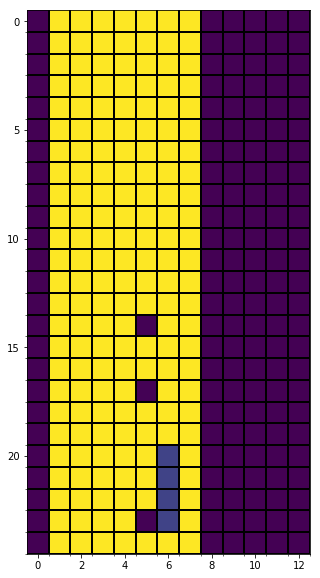

In [10]:
#case = 1 # car in front
#case = 2 # next to left side rail
#case = 3 # obstacle on the left
#case = 4 # next to right side rail
#case = 5 # obstacle on the right

(case, solution) = runCase(3)
if solution is None:
        print('no solution for case ',i)
else:
    plt.figure(figsize=(20,10))
    solution = np.reshape(solution,[patchesAhead + patchesBehind,patchesWidth]).tolist()
    im = plt.imshow(solution)
    ax = plt.gca();
    ax = plt.gca();

    # Minor ticks
    ax.set_xticks(np.arange(.5, patchesWidth, 1), minor=True);
    ax.set_yticks(np.arange(.5, patchesAhead + patchesBehind, 1), minor=True);
    ax.xaxis.label.set_color('w')
    ax.yaxis.label.set_color('w')

    # Gridlines based on minor ticks
    ax.grid(which='minor', color='black', linestyle='-', linewidth=2)